In [146]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [147]:
image = cv.imread('soduku.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
normal_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)


(551, 545)


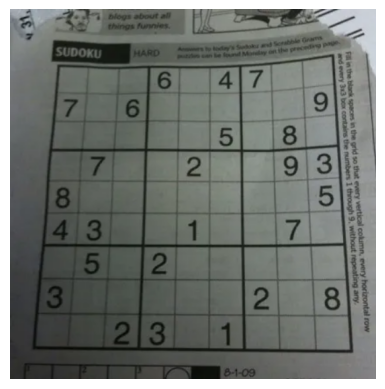

In [148]:
print(gray.shape)
plt.imshow(normal_image)
plt.axis('off')  
plt.show()

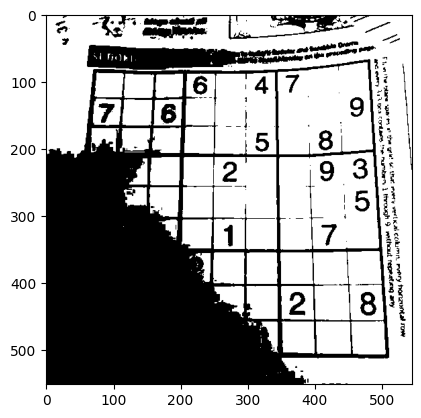

In [149]:
ret2,th2 = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(th2, cmap="gray")

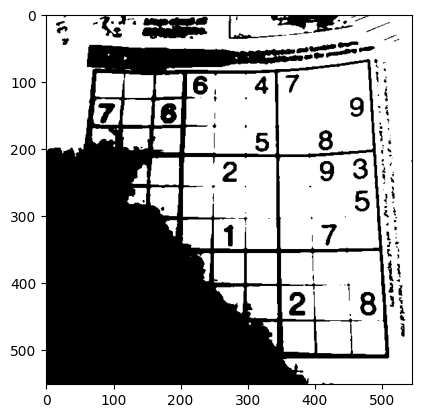

In [150]:
blur = cv.GaussianBlur(gray,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_OTSU)

plt.imshow(th3,cmap='gray')

In [151]:
edges = cv.Canny(gray, 10, 100)

In [152]:
cv.imshow("Edges", edges)
cv.waitKey(0)
cv.destroyAllWindows()

In [153]:
contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(image, contours, -1, (0, 255, 0), 2)

array([[[180, 173, 168],
        [180, 173, 168],
        [180, 173, 168],
        ...,
        [214, 207, 201],
        [214, 207, 201],
        [214, 207, 201]],

       [[178, 171, 165],
        [178, 171, 165],
        [178, 171, 165],
        ...,
        [214, 207, 201],
        [214, 207, 201],
        [214, 207, 201]],

       [[175, 168, 162],
        [175, 168, 162],
        [176, 168, 163],
        ...,
        [214, 207, 201],
        [214, 207, 201],
        [214, 207, 201]],

       ...,

       [[ 43,  46,  45],
        [ 43,  46,  45],
        [ 43,  46,  45],
        ...,
        [135, 132, 133],
        [135, 133, 133],
        [136, 134, 134]],

       [[ 43,  46,  45],
        [ 43,  46,  45],
        [ 43,  46,  45],
        ...,
        [135, 132, 133],
        [135, 133, 133],
        [136, 134, 134]],

       [[ 43,  46,  45],
        [ 43,  46,  45],
        [ 43,  46,  45],
        ...,
        [135, 132, 133],
        [135, 133, 133],
        [136, 134, 134]]

In [154]:
cv.imshow("Contours", image)
cv.waitKey(0)
cv.destroyAllWindows()

In [155]:
biggest_contour = max(contours, key=cv.contourArea)
cv.drawContours(image, [biggest_contour], -1, (255, 0, 0), 5)
cv.imshow("Contours", image)
cv.waitKey(0)
cv.destroyAllWindows()


In [156]:
contour_points = biggest_contour[:, 0, :].tolist()

max_x = max(contour_points, key=lambda x: x[0])[0]
min_x = min(contour_points, key=lambda x: x[0])[0]
max_y = max(contour_points, key=lambda x: x[1])[1]
min_y = min(contour_points, key=lambda x: x[1])[1]
p1 = (min_x, min_y)
p2 = (max_x, min_y)
p3 = (max_x, max_y)
p4 = (min_x, max_y)


In [157]:

cv.rectangle(image, p1, p3, (0, 0, 255), 4)  # Green color, thickness=2

cv.imshow("Rectangle", image)
cv.waitKey(0)
cv.destroyAllWindows()


In [158]:
epsilon = 0.02 * cv.arcLength(biggest_contour, True)  
approx = cv.approxPolyDP(biggest_contour, epsilon, True)

if len(approx) == 4:
    rectangle_points = approx.reshape(4, 2)
    print("Rectangle Corner Points:", rectangle_points)

    for i in range(4):
        cv.line(image, tuple(rectangle_points[i]), tuple(rectangle_points[(i+1) % 4]), (0, 255, 0), 2)

    cv.imshow("Rectangle Approximation", image)
    cv.waitKey(0)
    cv.destroyAllWindows()
else:
    print("The contour is not a perfect rectangle.")

Rectangle Corner Points: [[482  67]
 [ 70  83]
 [ 34 506]
 [510 511]]


In [159]:
image = cv.imread('soduku.png')
for i in range(4):
    cv.line(image, tuple(rectangle_points[i]), tuple(rectangle_points[(i+1) % 4]), (0, 255, 0), 2)
cv.imshow("Rectangle Approximation", image)
cv.waitKey(0)
cv.destroyAllWindows()



In [160]:
rectangle_points = sorted(rectangle_points, key=lambda x: (x[1], x[0]))
if rectangle_points[0][0] > rectangle_points[1][0]:  # Swap top-left and top-right if needed
    rectangle_points[0], rectangle_points[1] = rectangle_points[1], rectangle_points[0]
if rectangle_points[2][0] < rectangle_points[3][0]:  # Swap bottom-left and bottom-right if needed
    rectangle_points[2], rectangle_points[3] = rectangle_points[3], rectangle_points[2]

width = 252 
height = 252  
dst_points = np.array([
    [0, 0],        
    [width-1, 0],  
    [width-1, height-1], 
    [0, height-1] 
], dtype="float32")

M = cv.getPerspectiveTransform(np.float32(rectangle_points), dst_points)

warped = cv.warpPerspective(image, M, (width, height))
cv.imshow("Warped Perspective", warped)
cv.waitKey(0)
cv.destroyAllWindows()

In [161]:
gray_warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)

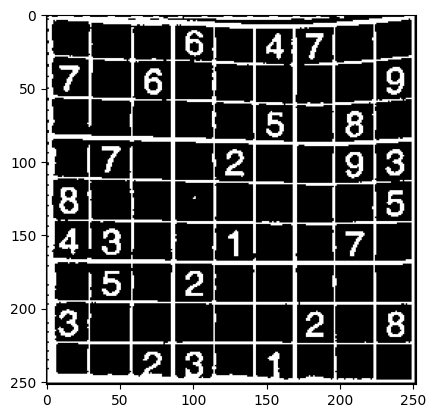

In [172]:
binary = cv.adaptiveThreshold(gray_warped, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV,15, 7)
plt.imshow(binary, cmap='gray')


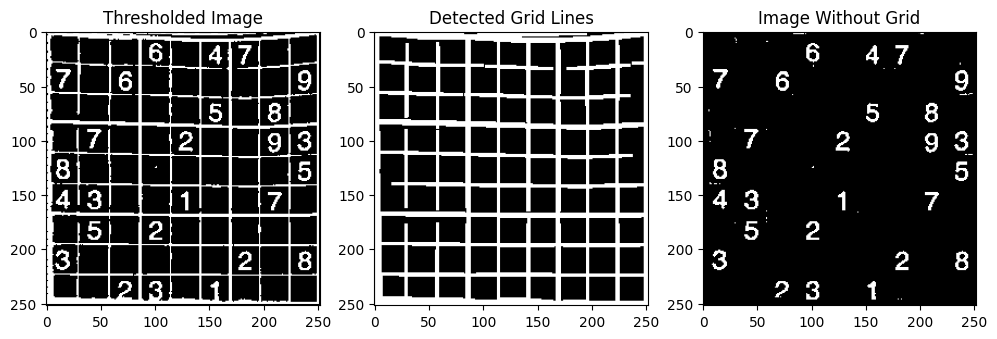

In [187]:
kernel_h = np.ones((1, 8), np.uint8) 
kernel_v = np.ones((12, 1), np.uint8)
horizontal_lines = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel_h, iterations=2)
kernel = np.ones((3,3), np.uint8)
vertical_lines = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel_v, iterations=2)
grid = cv.add(horizontal_lines, vertical_lines)
grid = cv.dilate(grid, kernel, iterations=1)
no_grid = cv.subtract(binary, grid)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.imshow(binary, cmap='gray'), plt.title("Thresholded Image")
plt.subplot(1, 3, 2), plt.imshow(grid, cmap='gray'), plt.title("Detected Grid Lines")
plt.subplot(1, 3, 3), plt.imshow(no_grid, cmap='gray'), plt.title("Image Without Grid")
plt.show()

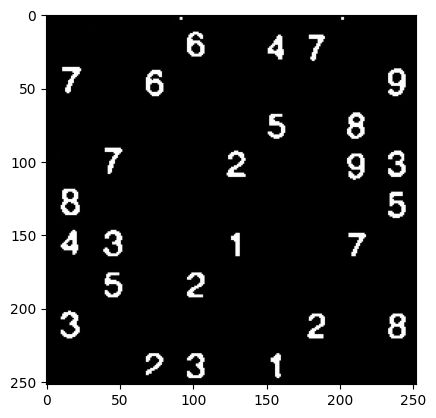

In [188]:
no_noise = cv.bilateralFilter(no_grid, 7, 90, 90)

no_noise = cv.medianBlur(no_noise, 3)
kernel = np.ones((2,2), np.uint8)  # Small kernel to remove noise

no_noise = cv.erode(no_noise, kernel, iterations=1)

no_noise = cv.dilate(no_noise, kernel, iterations=1)


plt.imshow(no_noise, cmap='gray')


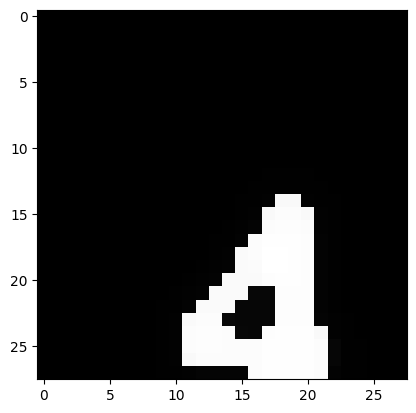

In [189]:

plt.imshow(no_noise[:28, 28*5:28*6], cmap='gray')


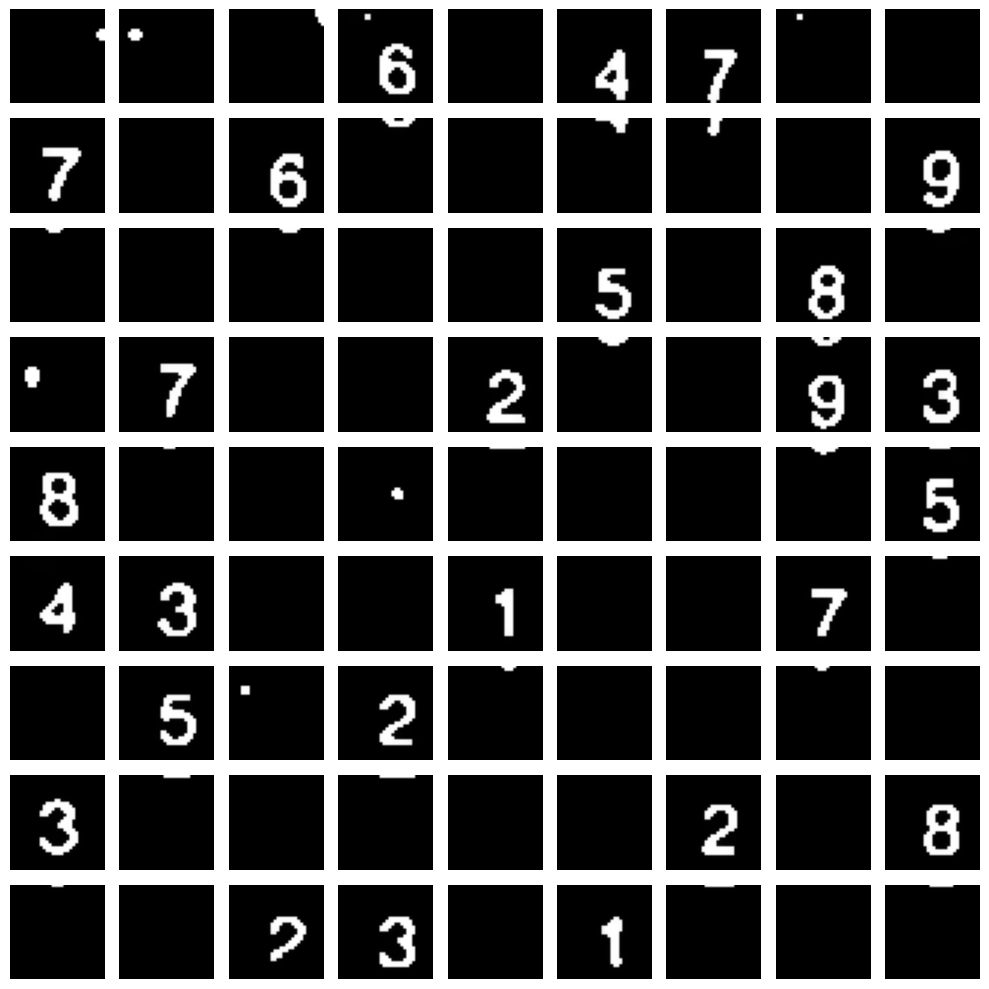

In [218]:
cell_size = 28  # Each cell is 28x28 pixels
grid_size = 9   # 9x9 Sudoku
new_size = 32

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

soduku_grid = []
soduku_idk = []

# Loop over each cell
for i in range(grid_size):
    for j in range(grid_size):
        # Extract the 28x28 cell from the image

        if i == 0 and j == 0:
            cell = no_noise[0:(i + 1) * new_size, 0:(j + 1) * new_size]
        
        elif i == 0 and j != 0 and j != 8:
            cell = no_noise[0:(i + 1) * new_size, (j * cell_size) - 2: ((j + 1) * cell_size) + 2]
        
        elif i == 0 and j == 8:
            cell = no_noise[0:(i + 1) * new_size, (j * cell_size) - 4: ((j + 1) * cell_size)]

        elif i == 8 and j == 0:
            cell = no_noise[(i * cell_size) - 4: ((i + 1) * cell_size), 0:(j + 1) * new_size]
        
        elif i == 8 and j == 8:
            cell = no_noise[(i * cell_size) - 4: ((i + 1) * cell_size), (j * cell_size) - 4: ((j + 1) * cell_size)]
        
        elif i == 8 and j != 0 and j != 8:
            cell = no_noise[(i * cell_size) - 4: ((i + 1) * cell_size), (j * cell_size) - 2: ((j + 1) * cell_size) + 2]
        
        elif i != 0 and i!= 8 and j == 0:
            cell = no_noise[(i * cell_size) - 2:((i + 1) * cell_size) + 2, 0:(j + 1) * new_size]
        
        elif i != 0 and i!= 8 and j == 8:
            cell = no_noise[(i * cell_size) - 2:((i + 1) * cell_size) + 2, (j * cell_size) - 4: ((j + 1) * cell_size)]
        
        elif i != 0 and i!= 8 and j != 0 and j != 8:
            cell = no_noise[(i * cell_size) -2 :((i + 1) * cell_size) + 2, (j * cell_size) -2:((j + 1) * cell_size) + 2]
        
        else: 
            print(f"i = {i}, j = {j}")

        
        # Display in the subplot

        soduku_idk.append(cell) 
        axes[i, j].imshow(cell, cmap='gray')
        axes[i, j].axis("off")  # Hide axes for clarity
    
    soduku_grid.append(soduku_idk)
    soduku_idk = []

plt.tight_layout()
plt.show()

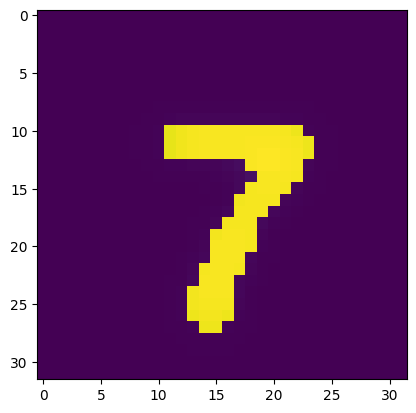

In [219]:
plt.imshow(soduku_grid[1][0])

In [220]:
np.mean(soduku_grid[1][0])

np.float64(23.072265625)

In [221]:
np.mean(soduku_grid[0][0])

np.float64(0.009765625)

In [222]:
np.mean(soduku_grid[2][0])

np.float64(0.009765625)

In [223]:
for i in range(grid_size):
    for j in range(grid_size):
        if np.mean(soduku_grid[i][j]) < 5:  # Adjust threshold
            soduku_grid[i][j] = np.zeros_like(soduku_grid[i][j]) 

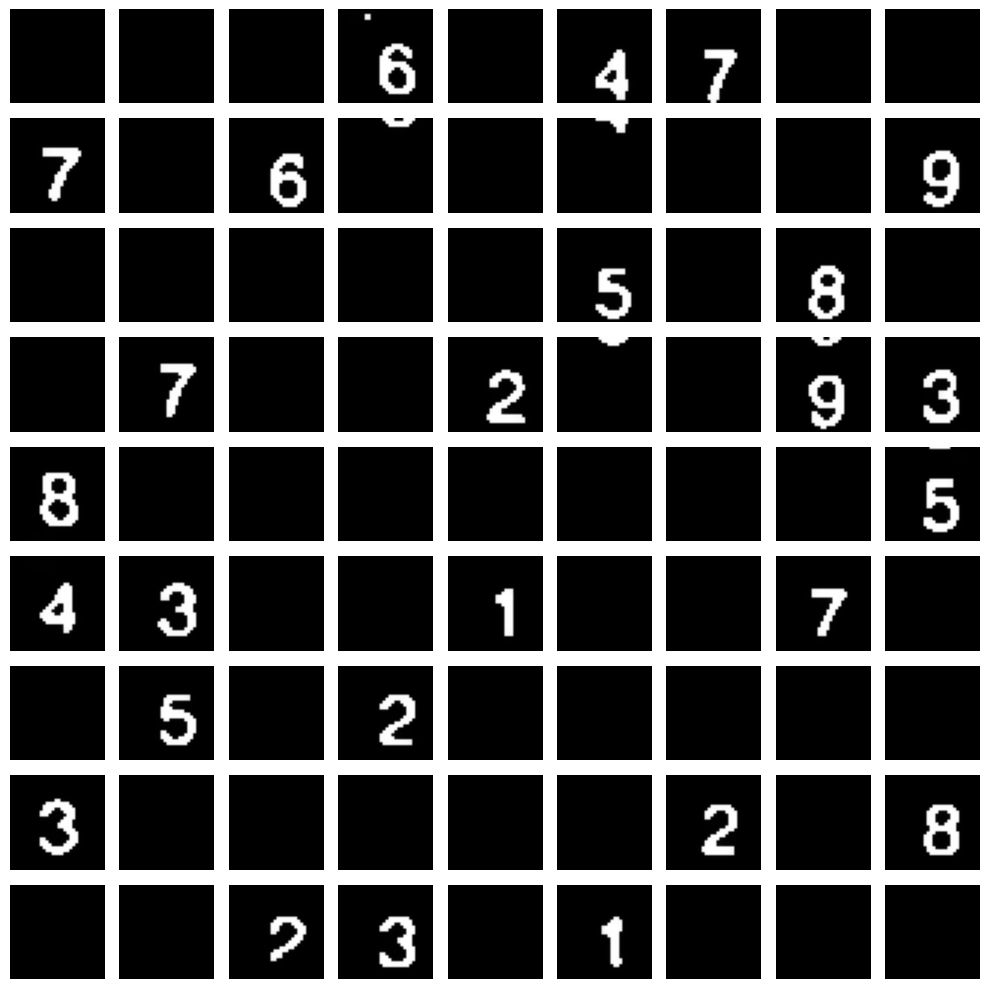

In [225]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(soduku_grid[i][j], cmap='gray')
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()